# 동물 이미지 Segmentation 챌린지

> 오픈소스 AI 응용 (2025-2)



# 데이터셋 준비

# Configuration (하이퍼파라미터, 경로 등 설정)

In [1]:
import os
import torch

# 고정되어야 하는 것. 바꾸지 말 것
IMAGE_SIZE = (256, 256)
N_CLASSES = 3  # trimap은 각 픽셀이 배경, 가장자리, 동물부분 이렇게 3개 중 하나의 클래스로 배정된 것

# Seeds
torch.manual_seed(0)

# Device settings
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data paths
IMAGE_PATH = 'train/images'
MAP_PATH = 'train/trimaps'

# Learning parameters
BATCH_SIZE = 16
LEARNING_RATE = 0.0005
EPOCHS = 1000

# Output paths
OUTPUT_PATH = 'train/output'
if not os.path.exists(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)
MODEL_PATH = os.path.join(OUTPUT_PATH, 'model_weight.pth')
HISTORY_PATH = os.path.join(OUTPUT_PATH, 'history.pickle')
HISTORY_PLOT_PATH = os.path.join(OUTPUT_PATH, 'history.png')  # 드라이브에 저장하고 싶다면 경로를 변경해야 함
HISTORY_LOGPLOT_PATH = os.path.join(OUTPUT_PATH, 'loghistory.png') 
PRED_PLOT_PATH = os.path.join(OUTPUT_PATH, 'pred.png')

# 데이터셋 클래스

In [2]:
import torch
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class TrimapsDataset(Dataset):
  def __init__(self, img_path, map_path='', test=False):
    super().__init__()

    self.istest=test

    # 이미지 경로의 리스트 생성
    self.img_path_list = sorted([
        os.path.join(img_path, name)
        for name in os.listdir(img_path)
        if name.endswith('.jpg')
    ])

    # 맵 경로의 리스트 생성, train 데이터에만 gt 맵 존재
    if not self.istest:
      self.map_path_list = sorted([
          os.path.join(map_path, name)
          for name in os.listdir(map_path)
          if name.endswith('.png')
      ])

    # 이미지 transform 정의 (리사이즈, 텐서로 변환)
    self.transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
    ])

  def __len__(self):
    return len(self.img_path_list)

  def __getitem__(self, idx):

    image_path = self.img_path_list[idx]
    # 데이터 id 추출. 결과제출시 필요
    data_id = image_path.split('/')[-1].split('.')[0].split('_')[-1]

    # 이미지 열어 RGB로 변경
    image = Image.open(image_path).convert('RGB')
    # 이미지 transform 적용
    image = self.transform(image)

    # train 데이터에만 gt 맵 존재
    if not self.istest:
      map_path = self.map_path_list[idx]
      # 맵 열어 grayscale 로 변경
      map = Image.open(map_path).convert('L')
      # 맵 transform 적용
      map = self.transform(map)
      # map은 0과 1 사이의 값으로 되어있으므로 255를 곱해 정수로 만듦
      map = map * 255
      map = map.squeeze().to(torch.int64)
      # GT 라벨은 1, 2, 3인데 분류 편의성을 위해 0, 1, 2로 변경
      map -= 1
      return image, map

    return image, data_id  # 채점을 위해 테스트 모드에서는 데이터 ID와 함께 반환



# 모델 클래스

In [3]:
import torch
from torch import nn
from typing import Optional

def get_norm_layer(num_channels, kind="bn"):
    if kind == "bn":
        return nn.BatchNorm2d(num_channels)
    elif kind == "gn":
        # 채널 수에 따라 그룹 수 자동 조절(8 또는 16 권장)
        groups = 16 if num_channels >= 32 else 8
        groups = min(groups, num_channels)
        return nn.GroupNorm(groups, num_channels)
    else:
        return nn.Identity()

class SEBlock(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(ch, ch // r, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch // r, ch, 1, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(self.pool(x))
        return x * w

class ResidualConv(nn.Module):
    def __init__(self, in_ch, out_ch, norm="bn", se=False, drop=0.0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            get_norm_layer(out_ch, norm), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            get_norm_layer(out_ch, norm)
        )
        self.act = nn.ReLU(inplace=True)
        self.proj = nn.Identity() if in_ch == out_ch else nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.se = SEBlock(out_ch) if se else nn.Identity()
        self.drop = nn.Dropout2d(p=drop) if drop > 0 else nn.Identity()
    def forward(self, x):
        res = self.proj(x)
        x = self.conv(x)
        x = self.se(x)
        x = self.drop(x)
        return self.act(x + res)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch, norm="bn", se=False, drop=0.0):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ResidualConv(in_ch, out_ch, norm=norm, se=se, drop=drop)
    def forward(self, x):
        return self.block(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, norm="bn", se=False, drop=0.0):
        super().__init__()
        # 업샘플은 bilinear + 1x1로 깔끔하게
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False),
            nn.Conv2d(in_ch, out_ch, 1, bias=False)
        )
        self.block = ResidualConv(out_ch*2, out_ch, norm=norm, se=se, drop=drop)
    def forward(self, x, skip):
        x = self.up(x)
        # 크기 보정(odd 입력일 때)
        if x.shape[-1] != skip.shape[-1] or x.shape[-2] != skip.shape[-2]:
            x = nn.functional.pad(x, (0, skip.shape[-1]-x.shape[-1], 0, skip.shape[-2]-x.shape[-2]))
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

class ASPP(nn.Module):
    """가볍게 쓸 수 있는 ASPP(선택). 멀티스케일 컨텍스트 강화."""
    def __init__(self, in_ch, out_ch, rates=(1, 6, 12, 18), norm="bn"):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1 if r==1 else 3, padding=0 if r==1 else r, dilation=r, bias=False),
                get_norm_layer(out_ch, norm),
                nn.ReLU(inplace=True)
            ) for r in rates
        ])
        self.project = nn.Sequential(
            nn.Conv2d(out_ch*len(rates), out_ch, 1, bias=False),
            get_norm_layer(out_ch, norm),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        feats = [b(x) for b in self.branches]
        x = torch.cat(feats, dim=1)
        return self.project(x)

class ImprovedUNet(nn.Module):
    """
    - in_channel: 입력 채널(예: RGB=3)
    - out_channel: 클래스 수(배경 포함)
    - img_size: (H,W) 안 써도 OK, 필요 시 검증용으로 들고만 다님
    - norm: 'bn' 또는 'gn'
    - use_aspp: 마지막 bottleneck에 ASPP 사용 여부
    """
    def __init__(self, in_channel, out_channel, img_size: Optional[tuple]=None,
                 base_ch=32, norm="bn", se=True, drop=0.1, use_aspp=False):
        super().__init__()
        self.img_size = img_size

        # Encoder
        self.enc1 = ResidualConv(in_channel,  base_ch,      norm=norm, se=se, drop=0.0)
        self.enc2 = Down(base_ch,             base_ch*2,    norm=norm, se=se, drop=drop)
        self.enc3 = Down(base_ch*2,           base_ch*4,    norm=norm, se=se, drop=drop)
        self.enc4 = Down(base_ch*4,           base_ch*8,    norm=norm, se=se, drop=drop)

        # Bottleneck
        self.bottleneck = ResidualConv(base_ch*8, base_ch*16, norm=norm, se=se, drop=drop)
        self.aspp = ASPP(base_ch*16, base_ch*16, rates=(1, 6, 12, 18), norm=norm) if use_aspp else nn.Identity()

        # Decoder
        self.up3 = Up(base_ch*16, base_ch*8,  norm=norm, se=se, drop=drop)
        self.up2 = Up(base_ch*8,  base_ch*4,  norm=norm, se=se, drop=drop)
        self.up1 = Up(base_ch*4,  base_ch*2,  norm=norm, se=se, drop=drop)
        self.up0 = Up(base_ch*2,  base_ch,    norm=norm, se=se, drop=0.0)

        self.head = nn.Conv2d(base_ch, out_channel, kernel_size=1)

        # 간단한 Kaiming init
        self.apply(self._init_weights)

    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)      # H
        e2 = self.enc2(e1)     # H/2
        e3 = self.enc3(e2)     # H/4
        e4 = self.enc4(e3)     # H/8

        # bottleneck (+ optional ASPP)
        b  = self.bottleneck(e4)
        b  = self.aspp(b)

        # decoder with skips
        d3 = self.up3(b,  e4)  # H/8
        d2 = self.up2(d3, e3)  # H/4
        d1 = self.up1(d2, e2)  # H/2
        d0 = self.up0(d1, e1)  # H
        logits = self.head(d0) # [B, out_channel, H, W]
        return logits


# 학습 함수

In [4]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import time
import pickle

def train(model, train_loader):

  model.train()

  loss_fn = CrossEntropyLoss()
  optim = Adam(model.parameters(), lr=LEARNING_RATE)

  history = {'train_loss': []}
  start_time = time.time()

  for epoch in range(EPOCHS):
    print('EPOCH: {}'.format(epoch))
    train_loss = 0.

    for i, (images, targets) in enumerate(train_loader):
      images, targets = images.to(DEVICE), targets.to(DEVICE)

      pred = model(images)
      loss = loss_fn(pred, targets)

      optim.zero_grad()
      loss.backward()
      optim.step()

      train_loss += loss*len(images)

    avg_train_loss = train_loss/len(train_loader.dataset)
    print('TRAIN LOSS: {}'.format(avg_train_loss))
    history['train_loss'].append(avg_train_loss.cpu().detach().numpy())

  # 학습 시간 측정
  end_time = time.time() - start_time
  print('Total time: {}s'.format(end_time))
  # 학습된 모델 파라미터 저장
  torch.save(model.state_dict(), MODEL_PATH)
  
    # Loss 그래프를 만들기 위한 히스토리 저장
  with open(HISTORY_PATH, 'wb', ) as f:
      pickle.dump(history, f)

# 학습 실행

In [5]:
from torch.utils.data import DataLoader

train_set = TrimapsDataset(IMAGE_PATH, MAP_PATH, test=False)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = ImprovedUNet(in_channel=3, out_channel=N_CLASSES, img_size=IMAGE_SIZE,
                     base_ch=32, norm="bn", se=True, drop=0.1, use_aspp=True)
model = model.to(DEVICE)

# train 함수 실행
train(model, train_loader)

EPOCH: 0
TRAIN LOSS: 0.6311100125312805
EPOCH: 1
TRAIN LOSS: 0.5024793744087219
EPOCH: 2
TRAIN LOSS: 0.43451258540153503
EPOCH: 3
TRAIN LOSS: 0.389331579208374
EPOCH: 4
TRAIN LOSS: 0.35967451333999634
EPOCH: 5
TRAIN LOSS: 0.3376931846141815
EPOCH: 6
TRAIN LOSS: 0.30740970373153687
EPOCH: 7
TRAIN LOSS: 0.29185304045677185
EPOCH: 8
TRAIN LOSS: 0.2699395716190338
EPOCH: 9
TRAIN LOSS: 0.2518974244594574
EPOCH: 10
TRAIN LOSS: 0.23990468680858612
EPOCH: 11
TRAIN LOSS: 0.22612635791301727
EPOCH: 12
TRAIN LOSS: 0.21165277063846588
EPOCH: 13
TRAIN LOSS: 0.1960349828004837
EPOCH: 14
TRAIN LOSS: 0.18898451328277588
EPOCH: 15
TRAIN LOSS: 0.1873796433210373
EPOCH: 16
TRAIN LOSS: 0.173426553606987
EPOCH: 17
TRAIN LOSS: 0.162471741437912
EPOCH: 18
TRAIN LOSS: 0.14706957340240479
EPOCH: 19
TRAIN LOSS: 0.15887874364852905
EPOCH: 20
TRAIN LOSS: 0.13793686032295227
EPOCH: 21
TRAIN LOSS: 0.12868152558803558
EPOCH: 22
TRAIN LOSS: 0.12261293083429337
EPOCH: 23
TRAIN LOSS: 0.1618667095899582
EPOCH: 24
TRAIN 

# 평가함수

In [6]:
# 평가 메트릭인 mIoU 계산 과정
def compute_iou_tensor(pred_map, target_map):
    intersection = (pred_map & target_map).sum(dim=(1, 2)).float()
    union = (pred_map | target_map).sum(dim=(1, 2)).float()
    iou = torch.where(union > 0, intersection / union, torch.ones_like(union))
    return iou

def eval(model, train_loader):
    model.eval()
    total_iou = torch.zeros(N_CLASSES).to(DEVICE)
    total_samples = 0

    with torch.no_grad():
        for i, (images, targets) in enumerate(train_loader):
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # 클래스별 mIoU 계산
            for cls in range(N_CLASSES):
                pred_map = (preds == cls)
                target_map = (targets == cls)

                iou = compute_iou_tensor(pred_map, target_map)
                total_iou[cls] += iou.sum()

            total_samples += images.size(0)

    mean_iou_per_class = total_iou / total_samples
    mIoU = mean_iou_per_class.mean().item()

    print(f"[EVAL] mIoU: {mIoU:.4f}")
    return mIoU

# 학습 데이터의 평가 결과 확인
챌린지 결과는 테스트 데이터에서 같은 방법으로 평가됨

In [ ]:
from torch.utils.data import DataLoader

train_set = TrimapsDataset(IMAGE_PATH, MAP_PATH, test=False)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model = ImprovedUNet(in_channel=3, out_channel=N_CLASSES, img_size=IMAGE_SIZE,
                     base_ch=32, norm="bn", se=True, drop=0.1, use_aspp=True)
model = model.to(DEVICE)

# train 함수 실행
train(model, train_loader)

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_21516\446229914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


[EVAL] mIoU: 0.9865


0.9865064024925232

#결과 제출
테스트 데이터에 대해 모델 수행 후 결과 파일 생성.

드라이브에 저장된 submission.csv 파일을 챌린지 사이트에 제출.

In [8]:
import numpy as np
import pandas as pd

# 테스트 데이터 다운로드 & unzip
#drive.mount('/content/drive')
#!cp "/content/drive/MyDrive/Colab Notebooks/project/dataset/test.zip" /content/
#!unzip /content/test.zip -d /content/testset

# RLE (Run Length Encoding) 함수. 파일 제출 형식을 맞추기 위해 필요. 수정하지 말 것
def rle_encode(mask):
    pixels = mask.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_rle(model, test_loader, save_path):
  model.eval()

  image_ids = []
  image_paths = []
  class_ids = []
  rles = []

  with torch.no_grad():
    for i, (images, data_id) in enumerate(test_loader):
      images = images.to(DEVICE)

      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)
      preds = preds.cpu().numpy()  # numpy로 변환

      for b in range(preds.shape[0]):
          pred_mask = preds[b] + 1  # 모델에서 편의를 위해 0, 1, 2로 변환했었기 때문에 되돌리기 위해 +1
          image_id = 'TEST_'+data_id[b]

          # 클래스별 RLE 인코딩 (1=foreground, 2=border, 3=background)
          for class_id in [1, 2, 3]:
              mask = (pred_mask == class_id).astype(np.uint8)
              rle = rle_encode(mask) if mask.sum() > 0 else ''

              image_ids.append(image_id)
              class_ids.append(class_id)
              rles.append(rle)

    # DataFrame 저장
    df = pd.DataFrame({
        'image_id': image_ids,
        'class_id': class_ids,
        'rle': rles
    })
    df.to_csv(save_path, index=False)
    print(f"RLE CSV file saved : {save_path}")

    return df

In [9]:
# Data paths
TEST_PATH = 'images'
SUBMISSION_FILE_PATH = 'submission/submission.csv'

test_set = TrimapsDataset(TEST_PATH, '', test=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model = ImprovedUNet(in_channel=3, out_channel=N_CLASSES, img_size=IMAGE_SIZE,
                     base_ch=32, norm="bn", se=True, drop=0.1, use_aspp=True)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)

get_rle(model, test_loader, SUBMISSION_FILE_PATH)

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_21516\3459553336.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


RLE CSV file saved : submission/submission.csv


,image_id,class_id,rle
0,TEST_0000,1,14977 5 15232 6 15488 8 15743 11 15997 14 1625...
1,TEST_0000,2,1 2 15 12150 12168 253 12426 251 12684 248 129...
2,TEST_0000,3,3 12 12165 3 12421 5 12677 7 12932 9 13187 11 ...
3,TEST_0001,1,155 74 412 72 664 77 920 77 1176 77 1431 78 16...
4,TEST_0001,2,1 154 244 168 500 164 756 152 910 10 1011 150 ...
...,...,...,...
3325,TEST_1108,2,2 35 60 50 132 125 258 255 514 255 770 255 102...
3326,TEST_1108,3,1 1 37 23 110 22 257 1 513 1 769 1 1025 1 1281...
3327,TEST_1109,1,235 22 493 7 506 2 510 3 767 2 1023 1 2681 1 3...
3328,TEST_1109,2,1 234 257 236 500 6 508 2 513 127 652 115 769 ...


# [참고 활용] Loss 그래프 확인 및 Trimap 도출 결과 확인



Loss 그래프 확인

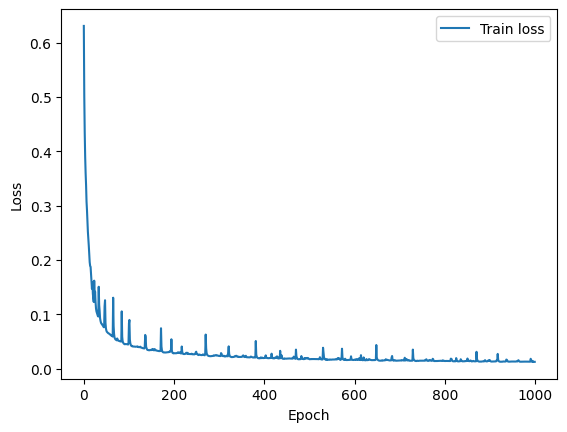

In [10]:
import matplotlib.pyplot as plt

# 저장한 Loss 히스토리 로드
with open(HISTORY_PATH, 'rb') as f:
    model_history = pickle.load(f)

# 그래프 만들어 이미지로 저장
plt.figure()
plt.plot(model_history['train_loss'], label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.savefig(HISTORY_PLOT_PATH)

# 로그 스케일 그래프

In [11]:
import matplotlib.pyplot as plt
import pickle

# 저장한 Loss 히스토리 로드
with open(HISTORY_PATH, 'rb') as f:
    model_history = pickle.load(f)

# 그래프 만들어 이미지로 저장
plt.figure()
plt.plot(model_history['train_loss'], label='Train loss')

# 로그 스케일 설정
plt.yscale('log')

plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend(loc='upper right')
plt.title('Training Loss (Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.savefig(HISTORY_LOGPLOT_PATH, dpi=200, bbox_inches='tight')
plt.close()

Trimap 도출 결과 확인

본 코드는 학습에 사용한 이미지를 랜덤하게 선택해 확인해 보는 것으로, 테스트 이미지에 좋은 성능을 보이는지와는 일치하지 않을 수 있음.

C:\Users\YoonHyeon\AppData\Local\Temp\ipykernel_21516\2006595615.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


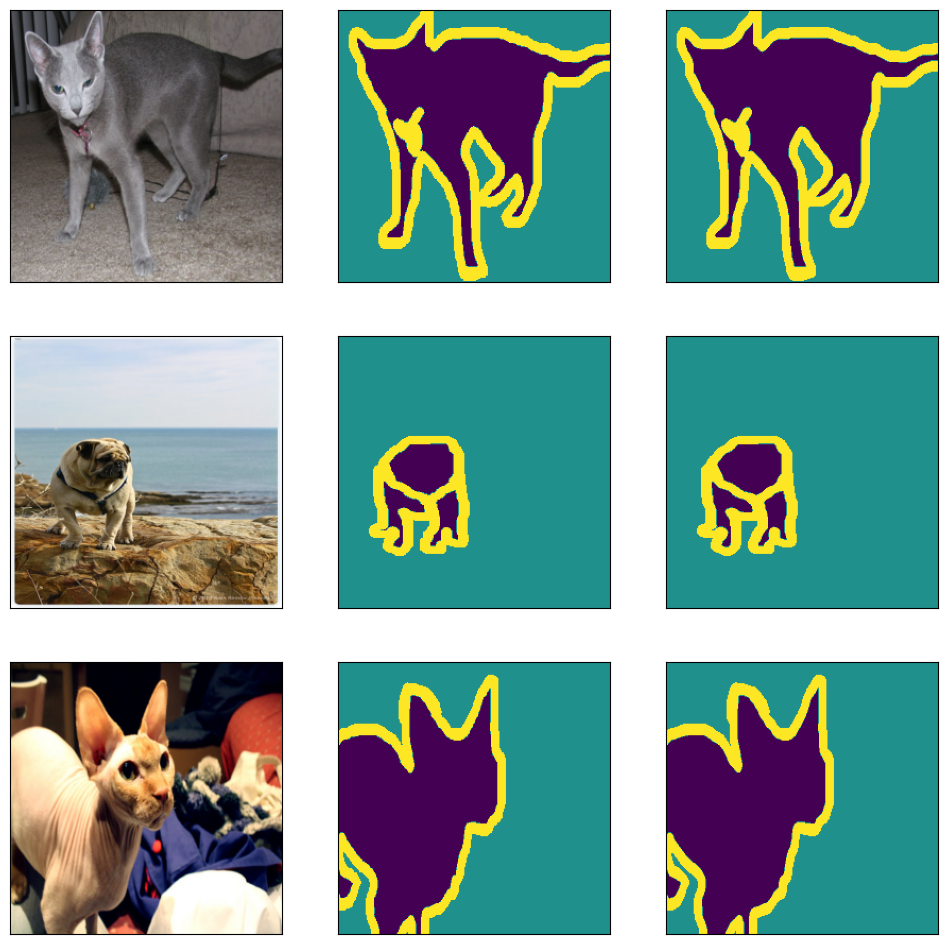

In [12]:
import random

# 저장된 모델 weight 로드
model = ImprovedUNet(in_channel=3, out_channel=N_CLASSES, img_size=IMAGE_SIZE,
                     base_ch=32, norm="bn", se=True, drop=0.1, use_aspp=True)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)
model.eval()

# 이미지 경로의 리스트 생성
img_path_list = sorted([
    os.path.join(IMAGE_PATH, name)
    for name in os.listdir(IMAGE_PATH)
    if name.endswith('.jpg')
])

# 맵 경로의 리스트 생성
map_path_list = sorted([
    os.path.join(MAP_PATH, name)
    for name in os.listdir(MAP_PATH)
    if name.endswith('.png')
])

# 랜덤한 세개의 인덱스 추출 후 이미지와 맵의 경로 저장
indices = random.sample(range(len(img_path_list) - 1), 3)
image_map_paths = {img_path_list[idx]: map_path_list[idx] for idx in indices}

# 이미지 transform 정의. 데이터셋 클래스와 같아야 함
transform = transforms.Compose([
transforms.Resize(IMAGE_SIZE),
transforms.ToTensor()
])

with torch.no_grad():
  figure, ax = plt.subplots(3, 3, figsize=(12, 12), subplot_kw={'xticks': [], 'yticks': []})

  for i, (image, map) in enumerate(image_map_paths.items()):
    # 이미지 로드 후 transform. 데이터셋 클래스와 같은 작업
    image = Image.open(image).convert('RGB')
    image = transform(image).to(DEVICE)
    image = torch.unsqueeze(image, dim=0) # 배치 dimension 추가

    # 모델 통과 후 예측 맵 생성
    pred = model(image).squeeze()
    pred = torch.argmax(pred, dim=0) # logit이 가장 큰 class 선택
    pred = pred.cpu().numpy()
    pred = pred * 255   # 이미지로 표시하기 위해 255 곱함

    # 정답 맵 로드
    map = Image.open(map).convert('L')
    map = transform(map)
    map = torch.squeeze(map, dim=0)
    map = map * 255
    map -= 1

    # 이미지 plot
    image = image.squeeze().permute(1, 2, 0).cpu()
    ax[i, 0].imshow(image)
    ax[i, 1].imshow(map)
    ax[i, 2].imshow(pred)

  # Save the plot
  figure.savefig(PRED_PLOT_PATH)